> > > >  # **Conolutional Neural Network Model**
> > > > > > > >  **( Cat Vs Dog Model )**

* Anmol Gupta

# **Convolutional Neural Network Model Structure for Image Classification**

![CNN Model structure](https://miro.medium.com/v2/resize:fit:1400/1*7_BCJFzekmPXmJQVRdDgwg.png)

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import keras_tuner
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Sample Image

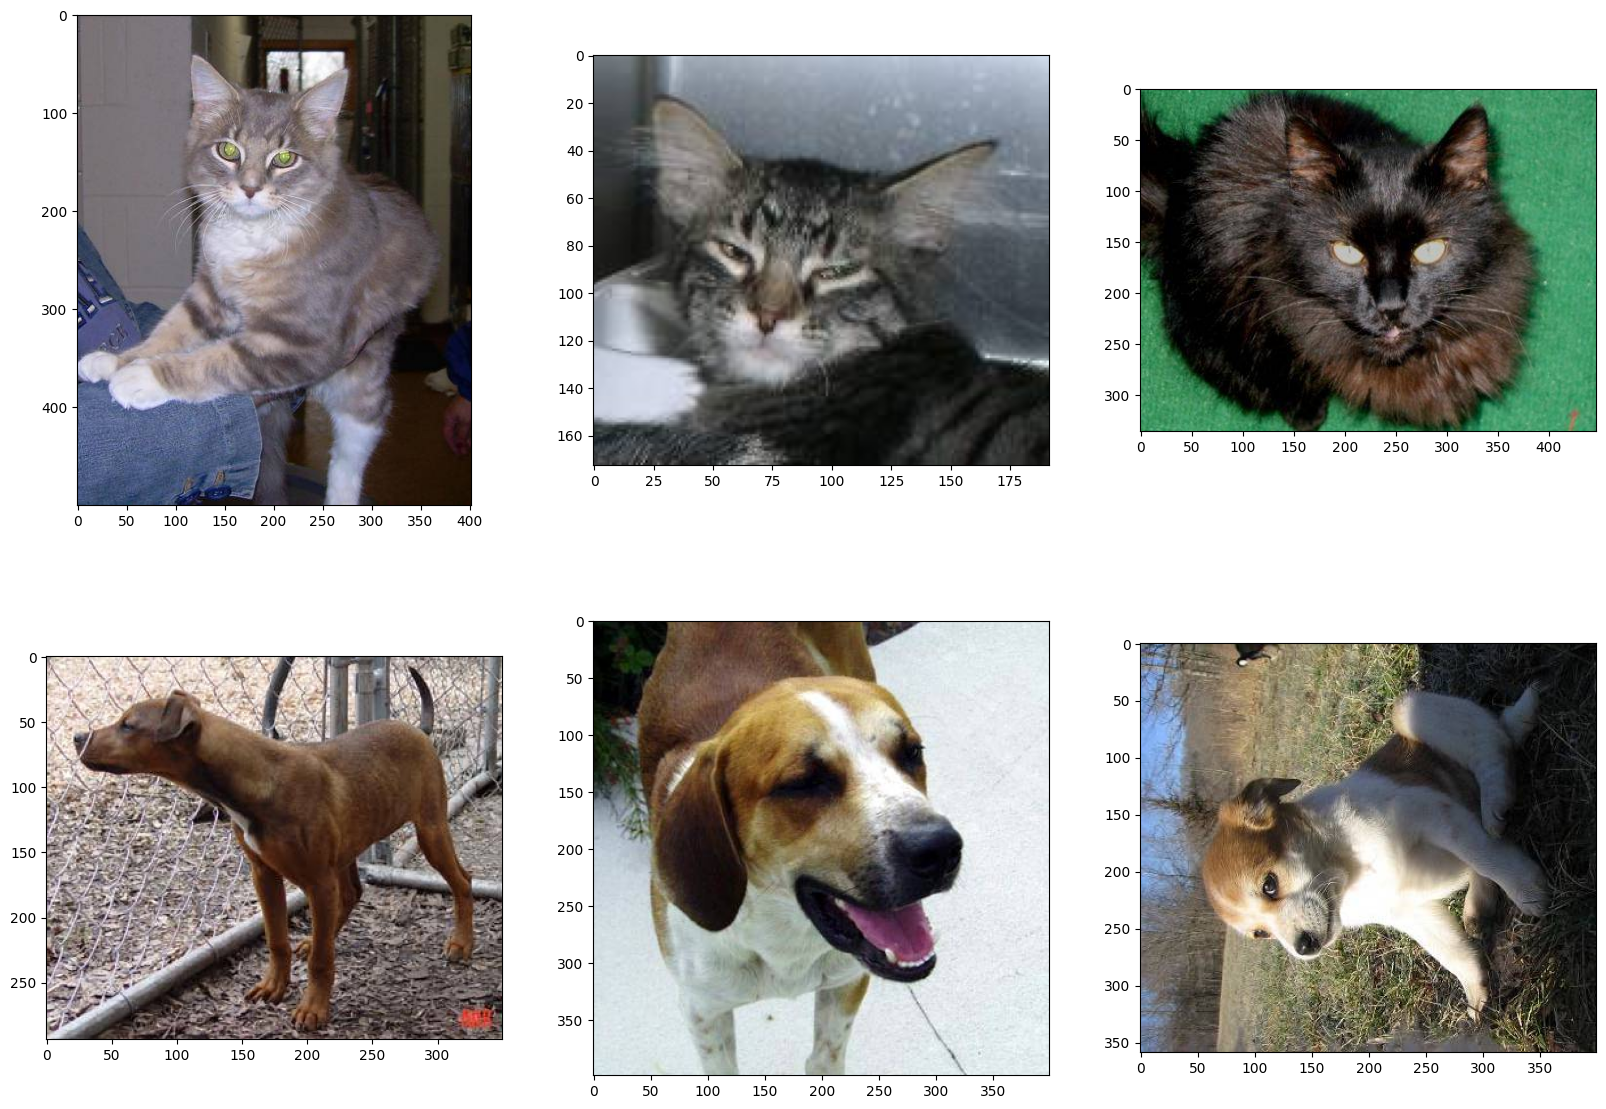

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_directory = '/kaggle/input/dogs-vs-cats/train/cats'
image_directory2 = '/kaggle/input/dogs-vs-cats/train/dogs'
image_files = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory)]
image_files2 = [os.path.join(image_directory2,filename) for filename in os.listdir(image_directory2)]
num_samples = 3  
selected_images = random.sample(image_files, num_samples)
selected_images2 = random.sample(image_files2,num_samples)
# Create subplots for displaying images
fig, axes = plt.subplots(2, num_samples, figsize=(20,14))

# Display each selected image
for i, image_path in enumerate(selected_images):
    ax = axes[0,i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis()
for i, image_path in enumerate(selected_images2):
    ax = axes[1,i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis()
# Show the images
plt.show()


We use generator because we have more than 10000 images

# **Train Data**

In [3]:
train_data = keras.utils.image_dataset_from_directory(directory= '/kaggle/input/dogs-vs-cats/train',
                                                     labels= 'inferred',
                                                     label_mode= 'int',
                                                     color_mode='rgb',
                                                     batch_size= 32,
                                                     image_size=(256,256))

Found 20000 files belonging to 2 classes.


# **Test Data**

In [4]:
validation_data = keras.utils.image_dataset_from_directory(directory= '/kaggle/input/dogs-vs-cats/test',
                                                    labels = 'inferred',
                                                    label_mode= 'int',
                                                    color_mode= 'rgb',
                                                    batch_size= 32,
                                                    image_size=(256,256))

Found 5000 files belonging to 2 classes.


# **Data Normalization**

In [5]:
def process(image,label):
    image = tensorflow.cast(image/255, dtype= 'float32')
    return image,label
train_data = train_data.map(process)
validation_data = validation_data.map(process)

In [6]:
print(train_data)
print(validation_data)

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# **Creating CNN Model**

In [7]:
def build_model(hp):
    model = keras.Sequential()
    num_conv_layer = hp.Int('num_conv_layer', min_value = 1, max_value = 5, step = 1)
    for i in range(num_conv_layer):
        model.add(keras.layers.Conv2D(filters = hp.Int(f'conv_{i}_filters', min_value = 32,
                                                      max_value = 256, step = 32),
                                     kernel_size= (3,3), padding = 'valid',activation= keras.activations.relu,
                                      input_shape = (256, 256, 3)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(pool_size= (2,2)))
    model.add(keras.layers.Flatten())
    
    #Tuning the numbre of dense layers...
    num_dense_layer = hp.Int('num_dense_layer', min_value = 1, max_value = 5, step = 1)
    for i in range(num_dense_layer):
        model.add(keras.layers.Dense(units= hp.Int(f'unit_{i}_layer', min_value = 32, max_value = 512,
                                                  step = 32),
                                    activation= keras.activations.relu,
                                    kernel_regularizer= keras.regularizers.l2(0.001)))
        model.add(keras.layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(1 , activation= keras.activations.sigmoid))
    
    learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate= learning_rate, amsgrad= True),
                 loss = keras.losses.binary_crossentropy,
                 metrics = ['accuracy'])
    return model
        

In [8]:
tuner = keras_tuner.RandomSearch(hypermodel = build_model, objective = 'val_accuracy',
                                max_trials = 4, max_retries_per_trial = 3,
                                directory = '/kaggle/working/',
                                project_name = 'Cat_vs_dog') 

In [9]:
tuner.search(train_data, epochs = 5, validation_data = validation_data)

Trial 4 Complete [00h 16m 04s]
val_accuracy: 0.843999981880188

Best val_accuracy So Far: 0.843999981880188
Total elapsed time: 01h 11m 23s


In [10]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [11]:

model1 = tuner.hypermodel.build(best_hps)


# **Our Convolutional Model**

In [12]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 96)      2688      
                                                                 
 batch_normalization_5 (Batc  (None, 254, 254, 96)     384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 96)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 256)     221440    
                                                                 
 batch_normalization_6 (Batc  (None, 125, 125, 256)    1024      
 hNormalization)                                                 
                                                      

# **Model Training**

In [13]:
history = model1.fit_generator(train_data,steps_per_epoch= len(train_data) ,epochs = 50, 
                               validation_data= validation_data, validation_steps= len(validation_data) )

Epoch 1/50


/tmp/ipykernel_23/1528098751.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(train_data,steps_per_epoch= len(train_data) ,epochs = 50,


625/625 [==============================] - 199s 310ms/step - loss: 1.0895 - accuracy: 0.6866 - val_loss: 1.0144 - val_accuracy: 0.7368
Epoch 2/50
625/625 [==============================] - 185s 295ms/step - loss: 0.9361 - accuracy: 0.7771 - val_loss: 0.9277 - val_accuracy: 0.7726
Epoch 3/50
625/625 [==============================] - 194s 310ms/step - loss: 0.8198 - accuracy: 0.8302 - val_loss: 0.8297 - val_accuracy: 0.8088
Epoch 4/50
625/625 [==============================] - 186s 297ms/step - loss: 0.7302 - accuracy: 0.8606 - val_loss: 0.7628 - val_accuracy: 0.8304
Epoch 5/50
625/625 [==============================] - 185s 296ms/step - loss: 0.6511 - accuracy: 0.8853 - val_loss: 0.7530 - val_accuracy: 0.8334
Epoch 6/50
625/625 [==============================] - 194s 309ms/step - loss: 0.5720 - accuracy: 0.9074 - val_loss: 0.6733 - val_accuracy: 0.8634
Epoch 7/50
625/625 [==============================] - 195s 310ms/step - loss: 0.4917 - accuracy: 0.9340 - val_loss: 0.6478 - val_accura

# **Graph Between accuracy Vs val_accuracy**

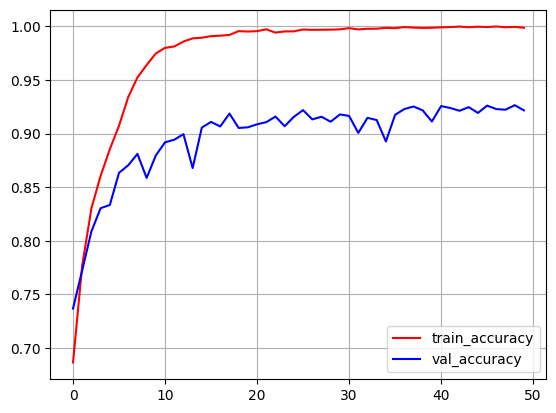

In [14]:
plt.plot(history.history['accuracy'], color = 'red',label = 'train_accuracy' )
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
plt.legend()
plt.grid()
plt.plot()
plt.show()

# **Graph Between loss Vs val_loss**

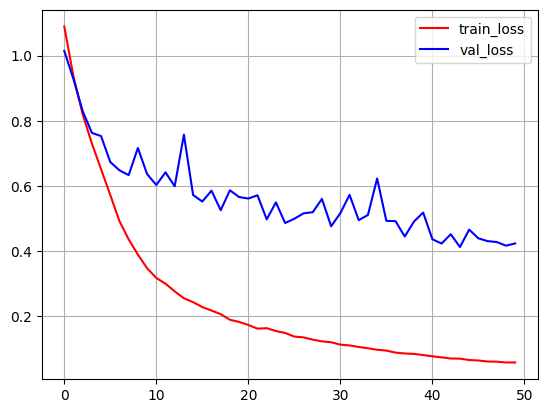

In [15]:
plt.plot(history.history['loss'], color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'val_loss')
plt.legend()
plt.grid()
plt.plot()
plt.show()

# **Retrain the model till the best number of epochs**

In [16]:
val_acc_per_epochs = history.history['val_accuracy']
best_epoch = val_acc_per_epochs.index(max(val_acc_per_epochs)) + 1
hypermodel = tuner.hypermodel.build(best_hps)

In [17]:
hypermodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 96)      2688      
                                                                 
 batch_normalization_10 (Bat  (None, 254, 254, 96)     384       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 96)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 256)     221440    
                                                                 
 batch_normalization_11 (Bat  (None, 125, 125, 256)    1024      
 chNormalization)                                                
                                                      

In [18]:
#Retrain the model....
hypermodel.fit(train_data,steps_per_epoch= len(train_data) ,epochs = best_epoch, 
                               validation_data= validation_data, validation_steps= len(validation_data))


Epoch 1/49
625/625 [==============================] - 198s 309ms/step - loss: 1.0754 - accuracy: 0.6956 - val_loss: 0.9978 - val_accuracy: 0.7444
Epoch 2/49
625/625 [==============================] - 186s 297ms/step - loss: 0.9119 - accuracy: 0.7882 - val_loss: 0.8562 - val_accuracy: 0.8116
Epoch 3/49
625/625 [==============================] - 195s 310ms/step - loss: 0.7980 - accuracy: 0.8360 - val_loss: 0.8368 - val_accuracy: 0.8010
Epoch 4/49
625/625 [==============================] - 195s 310ms/step - loss: 0.6991 - accuracy: 0.8714 - val_loss: 0.7283 - val_accuracy: 0.8462
Epoch 5/49
625/625 [==============================] - 194s 310ms/step - loss: 0.6149 - accuracy: 0.8982 - val_loss: 0.6769 - val_accuracy: 0.8714
Epoch 6/49
625/625 [==============================] - 194s 310ms/step - loss: 0.5361 - accuracy: 0.9229 - val_loss: 0.6137 - val_accuracy: 0.8830
Epoch 7/49
625/625 [==============================] - 185s 295ms/step - loss: 0.4730 - accuracy: 0.9399 - val_loss: 0.6503 -

# **Prediction on an image**

In [19]:
test_data = keras.utils.image_dataset_from_directory(directory= '/kaggle/input/cat-vs-dog-test1/Cat_vs_dog_test',
                                                     labels= 'inferred',
                                                     label_mode= 'int',
                                                     color_mode='rgb',
                                                     image_size=(256,256))

Found 13 files belonging to 2 classes.


In [20]:
prediction = hypermodel.predict_generator(test_data)
prediction = (prediction>0.5).astype(float)

/tmp/ipykernel_23/1882299007.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = hypermodel.predict_generator(test_data)


In [21]:
prediction

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]])